In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.visualize import cycle_plot, save_plot
from utils.make_dataset import LoadData, list_dataset, get_json, get_processed
from validate import make_tensor, load_model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets

In [61]:
featurenames = get_json('references/col_to_feat.json')
train = LoadData('train_FD001.txt', sep='\s+', names=featurenames)
train.features[:5]

array([[ 1.00000e+00,  1.00000e+00, -7.00000e-04, -4.00000e-04,
         1.00000e+02,  5.18670e+02,  6.41820e+02,  1.58970e+03,
         1.40060e+03,  1.46200e+01,  2.16100e+01,  5.54360e+02,
         2.38806e+03,  9.04619e+03,  1.30000e+00,  4.74700e+01,
         5.21660e+02,  2.38802e+03,  8.13862e+03,  8.41950e+00,
         3.00000e-02,  3.92000e+02,  2.38800e+03,  1.00000e+02,
         3.90600e+01,  2.34190e+01],
       [ 1.00000e+00,  2.00000e+00,  1.90000e-03, -3.00000e-04,
         1.00000e+02,  5.18670e+02,  6.42150e+02,  1.59182e+03,
         1.40314e+03,  1.46200e+01,  2.16100e+01,  5.53750e+02,
         2.38804e+03,  9.04407e+03,  1.30000e+00,  4.74900e+01,
         5.22280e+02,  2.38807e+03,  8.13149e+03,  8.43180e+00,
         3.00000e-02,  3.92000e+02,  2.38800e+03,  1.00000e+02,
         3.90000e+01,  2.34236e+01],
       [ 1.00000e+00,  3.00000e+00, -4.30000e-03,  3.00000e-04,
         1.00000e+02,  5.18670e+02,  6.42350e+02,  1.58799e+03,
         1.40420e+03,  1.46200

In [3]:
scaled_train, scaler = train.standardize()

In [4]:
class NN(nn.Module):
    """Neural Network Generator."""
    def __init__(self, input_size=24, hidden_sizes=[20,15], output_size=1, drop_p=0.4):
        """Generate fully-connected neural network.

        parameters
        ----------
        input_size (int): size of the input
        hidden_sizes (list of int): size of the hidden layers
        output_layer (int): size of the output layer
        drop_p (float): dropout probability
        """
        super().__init__()
        self.hidden_layers = nn.ModuleList([
            nn.Linear(input_size, hidden_sizes[0])
        ])
        layers = zip(hidden_sizes[:-1], hidden_sizes[1:])
        self.hidden_layers.extend([nn.Linear(h1,h2) for h1,h2 in layers])
        self.output = nn.Linear(hidden_sizes[-1], output_size)
        self.dropout = nn.Dropout(drop_p)
    
    def forward(self, X):
        for index, linear in enumerate(self.hidden_layers):
            if index % 2 == 0:
                X = linear(X)
                X = self.dropout(X)
            elif index % 2 != 0:
                X = torch.tanh(linear(X))
        
        X = self.output(X)

        return F.relu(X)
#         return X

In [5]:
def training(
    model,
    criterion,
    optimizer,
    featureloader,
    labelloader,
    epochs=5,
    print_every=40
):
    epoch_loss = 0
    steps = 0
    1
    for epoch in range(epochs):
        for features, labels in zip(featureloader, labelloader):
            steps += 1
            features, labels = features.type(torch.FloatTensor), labels.type(torch.FloatTensor)
            labels.resize_(labels.shape[0], 1)
            
            output = model.forward(features)
            loss = criterion(output, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if steps % print_every == 0:
                print('Epoch: {}/{}..'.format(epoch+1, epochs),
                      'Training loss: {:.3f}'.format(epoch_loss/print_every))

                epoch_loss = 0

In [8]:
featureset = torch.from_numpy(scaled_train[:,2:])
labelset = torch.from_numpy(train.target)

featureloader = torch.utils.data.DataLoader(featureset, batch_size=32)
labelloader = torch.utils.data.DataLoader(labelset, batch_size=32)

In [49]:
model = NN(hidden_sizes=[30, 15])

optimizer = optim.RMSprop(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

training(model, criterion, optimizer, featureloader, labelloader, epochs=150, print_every=60)

Epoch: 1/150.. Training loss: 15531.182
Epoch: 1/150.. Training loss: 12517.763
Epoch: 1/150.. Training loss: 8934.156
Epoch: 1/150.. Training loss: 8416.421
Epoch: 1/150.. Training loss: 10267.745
Epoch: 1/150.. Training loss: 9529.734
Epoch: 1/150.. Training loss: 10970.965
Epoch: 1/150.. Training loss: 11785.343
Epoch: 1/150.. Training loss: 10046.226
Epoch: 1/150.. Training loss: 10937.389
Epoch: 2/150.. Training loss: 10990.589
Epoch: 2/150.. Training loss: 7333.386
Epoch: 2/150.. Training loss: 5868.357
Epoch: 2/150.. Training loss: 4328.906
Epoch: 2/150.. Training loss: 3697.618
Epoch: 2/150.. Training loss: 5199.400
Epoch: 2/150.. Training loss: 5354.514
Epoch: 2/150.. Training loss: 9662.640
Epoch: 2/150.. Training loss: 3717.498
Epoch: 2/150.. Training loss: 6203.951
Epoch: 2/150.. Training loss: 9046.713
Epoch: 3/150.. Training loss: 4285.361
Epoch: 3/150.. Training loss: 2885.899
Epoch: 3/150.. Training loss: 3267.372
Epoch: 3/150.. Training loss: 2388.896
Epoch: 3/150.. Tr

Epoch: 20/150.. Training loss: 2303.453
Epoch: 20/150.. Training loss: 3430.868
Epoch: 20/150.. Training loss: 1410.082
Epoch: 20/150.. Training loss: 2956.633
Epoch: 20/150.. Training loss: 2254.077
Epoch: 21/150.. Training loss: 1426.261
Epoch: 21/150.. Training loss: 1222.212
Epoch: 21/150.. Training loss: 1110.459
Epoch: 21/150.. Training loss: 1086.684
Epoch: 21/150.. Training loss: 1022.481
Epoch: 21/150.. Training loss: 1553.831
Epoch: 21/150.. Training loss: 2688.191
Epoch: 21/150.. Training loss: 2662.355
Epoch: 21/150.. Training loss: 1788.234
Epoch: 21/150.. Training loss: 2820.229
Epoch: 22/150.. Training loss: 2315.658
Epoch: 22/150.. Training loss: 1034.271
Epoch: 22/150.. Training loss: 1319.971
Epoch: 22/150.. Training loss: 1190.979
Epoch: 22/150.. Training loss: 841.845
Epoch: 22/150.. Training loss: 926.436
Epoch: 22/150.. Training loss: 1671.119
Epoch: 22/150.. Training loss: 4139.507
Epoch: 22/150.. Training loss: 1279.267
Epoch: 22/150.. Training loss: 2001.446
Ep

Epoch: 39/150.. Training loss: 1905.247
Epoch: 39/150.. Training loss: 3220.176
Epoch: 40/150.. Training loss: 1619.721
Epoch: 40/150.. Training loss: 1274.412
Epoch: 40/150.. Training loss: 1051.775
Epoch: 40/150.. Training loss: 1080.373
Epoch: 40/150.. Training loss: 1066.366
Epoch: 40/150.. Training loss: 1045.725
Epoch: 40/150.. Training loss: 2309.104
Epoch: 40/150.. Training loss: 3548.723
Epoch: 40/150.. Training loss: 1378.170
Epoch: 40/150.. Training loss: 2916.951
Epoch: 40/150.. Training loss: 2211.051
Epoch: 41/150.. Training loss: 1353.567
Epoch: 41/150.. Training loss: 1209.752
Epoch: 41/150.. Training loss: 1100.046
Epoch: 41/150.. Training loss: 1072.185
Epoch: 41/150.. Training loss: 949.391
Epoch: 41/150.. Training loss: 1582.376
Epoch: 41/150.. Training loss: 2779.319
Epoch: 41/150.. Training loss: 2550.607
Epoch: 41/150.. Training loss: 1758.841
Epoch: 41/150.. Training loss: 2737.826
Epoch: 42/150.. Training loss: 2289.548
Epoch: 42/150.. Training loss: 1007.101
E

Epoch: 59/150.. Training loss: 910.552
Epoch: 59/150.. Training loss: 830.039
Epoch: 59/150.. Training loss: 1807.681
Epoch: 59/150.. Training loss: 4156.527
Epoch: 59/150.. Training loss: 1319.995
Epoch: 59/150.. Training loss: 1874.428
Epoch: 59/150.. Training loss: 3426.690
Epoch: 60/150.. Training loss: 1503.995
Epoch: 60/150.. Training loss: 1198.726
Epoch: 60/150.. Training loss: 1026.531
Epoch: 60/150.. Training loss: 1045.217
Epoch: 60/150.. Training loss: 1084.536
Epoch: 60/150.. Training loss: 1079.986
Epoch: 60/150.. Training loss: 2255.477
Epoch: 60/150.. Training loss: 3436.178
Epoch: 60/150.. Training loss: 1361.006
Epoch: 60/150.. Training loss: 2907.835
Epoch: 60/150.. Training loss: 2318.873
Epoch: 61/150.. Training loss: 1280.724
Epoch: 61/150.. Training loss: 1187.730
Epoch: 61/150.. Training loss: 1166.860
Epoch: 61/150.. Training loss: 1093.734
Epoch: 61/150.. Training loss: 940.063
Epoch: 61/150.. Training loss: 1496.820
Epoch: 61/150.. Training loss: 2680.625
Epo

Epoch: 78/150.. Training loss: 1183.250
Epoch: 78/150.. Training loss: 1975.461
Epoch: 78/150.. Training loss: 3387.584
Epoch: 79/150.. Training loss: 1556.070
Epoch: 79/150.. Training loss: 832.085
Epoch: 79/150.. Training loss: 1399.469
Epoch: 79/150.. Training loss: 1280.519
Epoch: 79/150.. Training loss: 898.548
Epoch: 79/150.. Training loss: 805.462
Epoch: 79/150.. Training loss: 1837.702
Epoch: 79/150.. Training loss: 4003.835
Epoch: 79/150.. Training loss: 1390.606
Epoch: 79/150.. Training loss: 1858.004
Epoch: 79/150.. Training loss: 3426.615
Epoch: 80/150.. Training loss: 1501.271
Epoch: 80/150.. Training loss: 1217.342
Epoch: 80/150.. Training loss: 1005.207
Epoch: 80/150.. Training loss: 1099.895
Epoch: 80/150.. Training loss: 1063.741
Epoch: 80/150.. Training loss: 1074.366
Epoch: 80/150.. Training loss: 2250.571
Epoch: 80/150.. Training loss: 3574.721
Epoch: 80/150.. Training loss: 1363.828
Epoch: 80/150.. Training loss: 2908.978
Epoch: 80/150.. Training loss: 2286.684
Epo

Epoch: 98/150.. Training loss: 1231.547
Epoch: 98/150.. Training loss: 864.198
Epoch: 98/150.. Training loss: 911.133
Epoch: 98/150.. Training loss: 1665.216
Epoch: 98/150.. Training loss: 4432.884
Epoch: 98/150.. Training loss: 1239.943
Epoch: 98/150.. Training loss: 1961.975
Epoch: 98/150.. Training loss: 3403.016
Epoch: 99/150.. Training loss: 1557.008
Epoch: 99/150.. Training loss: 784.685
Epoch: 99/150.. Training loss: 1420.332
Epoch: 99/150.. Training loss: 1244.540
Epoch: 99/150.. Training loss: 853.352
Epoch: 99/150.. Training loss: 828.383
Epoch: 99/150.. Training loss: 1837.207
Epoch: 99/150.. Training loss: 4235.252
Epoch: 99/150.. Training loss: 1356.104
Epoch: 99/150.. Training loss: 1908.385
Epoch: 99/150.. Training loss: 3499.021
Epoch: 100/150.. Training loss: 1545.565
Epoch: 100/150.. Training loss: 1201.619
Epoch: 100/150.. Training loss: 1020.630
Epoch: 100/150.. Training loss: 995.920
Epoch: 100/150.. Training loss: 1124.124
Epoch: 100/150.. Training loss: 1073.451


Epoch: 117/150.. Training loss: 941.703
Epoch: 117/150.. Training loss: 1504.837
Epoch: 117/150.. Training loss: 2892.248
Epoch: 117/150.. Training loss: 2623.312
Epoch: 117/150.. Training loss: 1735.530
Epoch: 117/150.. Training loss: 2866.989
Epoch: 118/150.. Training loss: 2270.177
Epoch: 118/150.. Training loss: 986.060
Epoch: 118/150.. Training loss: 1333.390
Epoch: 118/150.. Training loss: 1288.184
Epoch: 118/150.. Training loss: 861.349
Epoch: 118/150.. Training loss: 884.081
Epoch: 118/150.. Training loss: 1676.646
Epoch: 118/150.. Training loss: 4219.047
Epoch: 118/150.. Training loss: 1173.664
Epoch: 118/150.. Training loss: 2026.583
Epoch: 118/150.. Training loss: 3222.055
Epoch: 119/150.. Training loss: 1604.796
Epoch: 119/150.. Training loss: 801.979
Epoch: 119/150.. Training loss: 1462.086
Epoch: 119/150.. Training loss: 1236.756
Epoch: 119/150.. Training loss: 855.121
Epoch: 119/150.. Training loss: 866.910
Epoch: 119/150.. Training loss: 1826.056
Epoch: 119/150.. Traini

Epoch: 136/150.. Training loss: 1136.510
Epoch: 136/150.. Training loss: 2282.495
Epoch: 136/150.. Training loss: 3733.637
Epoch: 136/150.. Training loss: 1321.876
Epoch: 136/150.. Training loss: 3032.708
Epoch: 136/150.. Training loss: 2300.346
Epoch: 137/150.. Training loss: 1301.163
Epoch: 137/150.. Training loss: 1230.784
Epoch: 137/150.. Training loss: 1184.752
Epoch: 137/150.. Training loss: 1147.119
Epoch: 137/150.. Training loss: 964.931
Epoch: 137/150.. Training loss: 1533.767
Epoch: 137/150.. Training loss: 2806.376
Epoch: 137/150.. Training loss: 2533.216
Epoch: 137/150.. Training loss: 1763.363
Epoch: 137/150.. Training loss: 2813.672
Epoch: 138/150.. Training loss: 2308.671
Epoch: 138/150.. Training loss: 1016.552
Epoch: 138/150.. Training loss: 1279.378
Epoch: 138/150.. Training loss: 1279.340
Epoch: 138/150.. Training loss: 879.474
Epoch: 138/150.. Training loss: 943.586
Epoch: 138/150.. Training loss: 1654.846
Epoch: 138/150.. Training loss: 4365.064
Epoch: 138/150.. Tr

In [52]:
# save the model
def save_model(model, epochs, optimizer, filename='checkpoint.pth', save_dir='reports'):
    checkpoint = {
        'model': model,
        'model_state': model.state_dict(),
        'epochs': epochs,
        'optim': optimizer,
        'optim_state': optimizer.state_dict()
    }
    torch.save(checkpoint, os.path.join(save_dir, filename))
    print('[INFO] model is saved!')

# save_model(model, 100, optimizer)

[INFO] model is saved!


/Users/syahrulhamdani/anaconda3/envs/100DaysOfMLCode/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type NN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [63]:
# load the model
checkpoint = torch.load('reports/model/checkpoint.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state'])
scaler = checkpoint['scaler']

In [64]:
test = pd.read_csv('data/raw/test_FD001.txt', sep='\s+', names=featurenames)
test.loc[test['EngineID']==1]

,EngineID,Cycle,OpSetting1,OpSetting2,OpSetting3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
5,1,6,0.0012,0.0003,100.0,518.67,642.11,1579.12,1395.13,14.62,...,521.92,2388.08,8127.46,8.4238,0.03,392,2388,100.0,38.91,23.3467
6,1,7,-0.0000,0.0002,100.0,518.67,642.11,1583.34,1404.84,14.62,...,522.01,2388.06,8134.97,8.3914,0.03,391,2388,100.0,38.85,23.3952
7,1,8,0.0006,-0.0000,100.0,518.67,642.54,1580.89,1400.89,14.62,...,522.09,2388.06,8125.93,8.4213,0.03,393,2388,100.0,39.05,23.3224
8,1,9,-0.0036,0.0000,100.0,518.67,641.88,1593.29,1412.28,14.62,...,522.03,2388.05,8134.15,8.4353,0.03,391,2388,100.0,39.10,23.4521
9,1,10,-0.0025,-0.0001,100.0,518.67,642.07,1585.25,1398.64,14.62,...,522.00,2388.06,8134.08,8.4093,0.03,391,2388,100.0,38.87,23.3820


In [65]:
scaled_test = scaler.transform(test)
scaled_test[:5]

/Users/syahrulhamdani/anaconda3/envs/100DaysOfMLCode/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[-1.72808356, -1.56517022,  1.0555991 ,  1.01567674,  0.        ,
         0.        ,  0.6780771 , -0.85355045, -1.19148011, -1.        ,
         0.14168333,  0.60140814, -0.798093  , -0.68257883,  0.        ,
        -1.27739615,  0.41561385, -0.91984139, -0.95423545, -0.98510705,
        -1.        , -0.78170979,  0.        ,  0.        ,  0.24194337,
         0.77409693],
       [-1.72808356, -1.55065208, -1.23036553, -1.03172035,  0.        ,
         0.        , -1.94170729, -0.33813706, -1.50146679, -1.        ,
         0.14168333,  1.67476859, -1.22072489, -0.49011738,  0.        ,
        -0.15414109,  1.01219529, -0.50269485, -0.21664836, -1.64903395,
        -1.        , -0.13601757,  0.        ,  0.        ,  1.12718287,
         0.94130518],
       [-1.72808356, -1.53613393,  0.14121325,  0.33321104,  0.        ,
         0.        , -0.44183073, -0.58442637, -0.84371727, -1.        ,
         0.14168333,  0.83867729, -0.6572157 , -0.37509336,  0.        ,
       

In [67]:
scaled_train = scaler.transform(train.features)
inferenceset = torch.from_numpy(scaled_train[:,2:]).type(torch.FloatTensor)
with torch.no_grad():
    infer_output = model(inferenceset)

In [69]:
infer_output[:192]

tensor([[180.9991],
        [180.9911],
        [176.5976],
        [180.9973],
        [159.2342],
        [181.0002],
        [159.3332],
        [180.9983],
        [180.9827],
        [179.6309],
        [177.5741],
        [180.8754],
        [157.6549],
        [161.2913],
        [149.3891],
        [157.5995],
        [157.6592],
        [157.4786],
        [158.8356],
        [180.9738],
        [161.8561],
        [180.2993],
        [181.0002],
        [157.6581],
        [179.9281],
        [180.1674],
        [180.4191],
        [180.8841],
        [179.5029],
        [180.9758],
        [180.9914],
        [181.0002],
        [165.4376],
        [157.6388],
        [161.1194],
        [181.0002],
        [181.0002],
        [115.1318],
        [180.9996],
        [175.2312],
        [175.2744],
        [157.6599],
        [175.1097],
        [180.5121],
        [157.6565],
        [169.4646],
        [181.0001],
        [160.1918],
        [180.9861],
        [157.7426],


In [23]:
rul_test = pd.read_csv('data/raw/RUL_FD001.txt', sep='\n', names=['RUL'])
rul_test.shape

(100, 1)

In [70]:
infer_output[30]

tensor([180.9914])

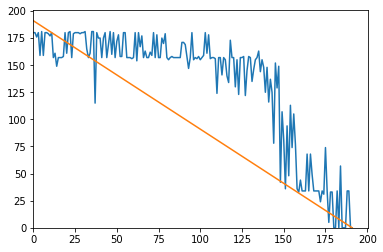

In [71]:
np_output = infer_output.numpy()
np_output = np_output.reshape(np_output.shape[0]).astype(np.int)
plt.plot(range(192), np_output[:192])
plt.plot(range(192), train.target[:192])
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.show()

In [4]:
!ls data/processed/

train_FD001_Oct-30-18_p.csv


In [24]:
data = get_processed('train_FD001_Oct-30-18_p.csv')
data.head(192)

,EngineID,Cycle,OpSetting1,OpSetting2,OpSetting3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL
0,-1.728,-1.565,-0.316,-1.373,0.0,0.0,-1.722,-0.134,-0.926,-1.0,...,-1.059,-0.269,-0.604,-1.0,-0.782,0.0,0.0,1.348,1.194,191.0
1,-1.728,-1.551,0.873,-1.032,0.0,0.0,-1.062,0.212,-0.644,-1.0,...,-0.364,-0.643,-0.276,-1.0,-0.782,0.0,0.0,1.017,1.237,190.0
2,-1.728,-1.536,-1.962,1.016,0.0,0.0,-0.662,-0.413,-0.526,-1.0,...,-0.920,-0.552,-0.649,-1.0,-2.073,0.0,0.0,0.740,0.503,189.0
3,-1.728,-1.522,0.324,-0.008,0.0,0.0,-0.662,-1.261,-0.785,-1.0,...,-0.225,-0.520,-1.972,-1.0,-0.782,0.0,0.0,0.353,0.778,188.0
4,-1.728,-1.507,-0.865,-0.690,0.0,0.0,-0.622,-1.252,-0.302,-1.0,...,-0.781,-0.522,-0.340,-1.0,-0.136,0.0,0.0,0.463,1.060,187.0
5,-1.728,-1.493,-1.962,-0.349,0.0,0.0,-1.162,-0.987,-1.174,-1.0,...,-0.920,-0.572,-0.836,-1.0,-1.427,0.0,0.0,0.906,0.713,186.0
6,-1.728,-1.478,0.461,0.333,0.0,0.0,-0.402,0.293,-1.240,-1.0,...,-0.920,-0.599,-1.193,-1.0,-0.782,0.0,0.0,1.570,0.810,185.0
7,-1.728,-1.464,-1.550,1.016,0.0,0.0,-0.242,-1.234,-0.885,-1.0,...,-0.920,-0.665,-0.921,-1.0,-1.427,0.0,0.0,0.851,0.193,184.0
8,-1.728,-1.449,0.370,0.333,0.0,0.0,-1.122,0.075,-1.570,-1.0,...,-0.642,-0.947,-1.849,-1.0,-0.782,0.0,0.0,1.293,1.080,183.0
9,-1.728,-1.435,-1.505,0.333,0.0,0.0,-1.942,0.117,-0.941,-1.0,...,-0.503,-0.753,-0.361,-1.0,-0.136,0.0,0.0,0.740,1.660,182.0


In [27]:
raw = pd.read_csv('data/raw/train_FD001.txt', header=None, sep='\s+')
raw.head(192)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,522.32,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,522.47,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,521.79,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,521.79,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694


In [32]:
data['EngineID'].nunique()

100

In [33]:
np.unique(data['EngineID'])

array([-1.728, -1.694, -1.66 , -1.625, -1.591, -1.557, -1.523, -1.489,
       -1.454, -1.42 , -1.386, -1.352, -1.318, -1.283, -1.249, -1.215,
       -1.181, -1.146, -1.112, -1.078, -1.044, -1.01 , -0.975, -0.941,
       -0.907, -0.873, -0.838, -0.804, -0.77 , -0.736, -0.702, -0.667,
       -0.633, -0.599, -0.565, -0.531, -0.496, -0.462, -0.428, -0.394,
       -0.359, -0.325, -0.291, -0.257, -0.223, -0.188, -0.154, -0.12 ,
       -0.086, -0.052, -0.017,  0.017,  0.051,  0.085,  0.12 ,  0.154,
        0.188,  0.222,  0.256,  0.291,  0.325,  0.359,  0.393,  0.427,
        0.462,  0.496,  0.53 ,  0.564,  0.599,  0.633,  0.667,  0.701,
        0.735,  0.77 ,  0.804,  0.838,  0.872,  0.906,  0.941,  0.975,
        1.009,  1.043,  1.078,  1.112,  1.146,  1.18 ,  1.214,  1.249,
        1.283,  1.317,  1.351,  1.385,  1.42 ,  1.454,  1.488,  1.522,
        1.557,  1.591,  1.625,  1.659])

In [31]:
len_cycle = dict()
for e in range(1,101):
    length = len(raw[raw[0]==e])
    rul = list(range(length-1, -1, -1))
    len_cycle[length] = rul
len_cycle

{192: [191,
  190,
  189,
  188,
  187,
  186,
  185,
  184,
  183,
  182,
  181,
  180,
  179,
  178,
  177,
  176,
  175,
  174,
  173,
  172,
  171,
  170,
  169,
  168,
  167,
  166,
  165,
  164,
  163,
  162,
  161,
  160,
  159,
  158,
  157,
  156,
  155,
  154,
  153,
  152,
  151,
  150,
  149,
  148,
  147,
  146,
  145,
  144,
  143,
  142,
  141,
  140,
  139,
  138,
  137,
  136,
  135,
  134,
  133,
  132,
  131,
  130,
  129,
  128,
  127,
  126,
  125,
  124,
  123,
  122,
  121,
  120,
  119,
  118,
  117,
  116,
  115,
  114,
  113,
  112,
  111,
  110,
  109,
  108,
  107,
  106,
  105,
  104,
  103,
  102,
  101,
  100,
  99,
  98,
  97,
  96,
  95,
  94,
  93,
  92,
  91,
  90,
  89,
  88,
  87,
  86,
  85,
  84,
  83,
  82,
  81,
  80,
  79,
  78,
  77,
  76,
  75,
  74,
  73,
  72,
  71,
  70,
  69,
  68,
  67,
  66,
  65,
  64,
  63,
  62,
  61,
  60,
  59,
  58,
  57,
  56,
  55,
  54,
  53,
  52,
  51,
  50,
  49,
  48,
  47,
  46,
  45,
  44,
  43,
  42,
  4

In [77]:
model, o, e, scaler = load_model('reports/model/checkpoint.pth')
scaled_data = torch.from_numpy(data.iloc[:,:-1].values).type(torch.FloatTensor)

In [78]:
scaled_data

tensor([[-1.7280, -1.5650, -0.3160,  ...,  0.0000,  1.3480,  1.1940],
        [-1.7280, -1.5510,  0.8730,  ...,  0.0000,  1.0170,  1.2370],
        [-1.7280, -1.5360, -1.9620,  ...,  0.0000,  0.7400,  0.5030],
        ...,
        [ 1.6590,  1.2950,  0.1870,  ...,  0.0000, -2.0820, -3.2920],
        [ 1.6590,  1.3090, -0.4990,  ...,  0.0000, -2.9120, -2.0850],
        [ 1.6590,  1.3240, -1.4590,  ...,  0.0000, -2.4690, -2.1940]])

In [79]:
with torch.no_grad():
    output = model(scaled_data[:, 2:])
output[:192]

tensor([[180.7821],
        [159.6520],
        [158.5442],
        [180.7406],
        [171.4070],
        [181.0002],
        [180.5716],
        [181.0002],
        [156.9990],
        [180.3569],
        [177.8887],
        [181.0002],
        [156.8789],
        [158.1102],
        [157.6772],
        [157.8197],
        [157.6917],
        [180.9854],
        [159.9205],
        [181.0002],
        [180.9636],
        [173.2219],
        [160.7406],
        [157.6592],
        [179.6237],
        [178.9602],
        [180.0336],
        [159.3716],
        [181.0002],
        [180.9951],
        [180.9939],
        [181.0000],
        [157.6490],
        [157.6592],
        [171.6260],
        [180.6387],
        [176.5426],
        [161.4950],
        [180.9788],
        [178.6231],
        [180.5345],
        [157.6648],
        [180.6898],
        [173.9362],
        [157.6567],
        [157.6592],
        [180.9849],
        [159.4807],
        [180.9907],
        [157.6590],


In [107]:
# convert output to dataframe
concat_output = np.concatenate(
    (data['EngineID'].values.reshape(data.shape[0], -1), output.numpy().reshape(output.size()[0], -1)),
    axis=1
)
engineid = np.unique(concat_output[:, 0])
df_output = pd.DataFrame(concat_output, columns=['EngineID', 'Output'])
df_output.loc[df_output['EngineID']==engineid[20], 'Output']

4168    180.807388
4169    180.999924
4170    157.274307
4171    157.660828
4172    157.965927
4173    180.972519
4174    158.033493
4175    161.126419
4176    175.879303
4177    144.385010
4178    168.751724
4179    160.633408
4180    157.414413
4181    157.748001
4182    157.519974
4183    157.588333
4184    157.657852
4185    160.469894
4186    180.102707
4187    157.628082
4188    157.647995
4189    180.999893
4190    157.659088
4191    157.817963
4192    157.214981
4193    159.454773
4194    180.619568
4195    157.659103
4196    157.659103
4197    180.729752
           ...    
4333     34.049305
4334     33.947041
4335     34.047565
4336     34.046535
4337      0.000000
4338     34.042652
4339      7.237753
4340     32.127575
4341     34.035938
4342      0.000000
4343      0.000000
4344     34.045345
4345      0.000000
4346      0.000000
4347     64.961639
4348      0.000000
4349      0.000000
4350      0.000000
4351     34.049068
4352     32.853733
4353      0.000000
4354      0.

In [92]:
data['EngineID'].values.reshape(data.shape[0], -1).shape
# output.numpy().reshape(output.size()[0], -1).shape

(20631, 1)

In [116]:
df_output[df_output['EngineID']==engineid[20]]

,EngineID,Output
4168,-1.044,180.807388
4169,-1.044,180.999924
4170,-1.044,157.274307
4171,-1.044,157.660828
4172,-1.044,157.965927
4173,-1.044,180.972519
4174,-1.044,158.033493
4175,-1.044,161.126419
4176,-1.044,175.879303
4177,-1.044,144.385010


In [118]:
len(raw.loc[raw[0]==21])

195